# Two Moons
This notebook demonstrates how to utilize BayesFlow to train a neural network to approximate data posterior distributions.

### Install dependencies

Please ensure you have a BayesFlow-compatible Python version installed.

#### For conda (recommended):

In [ ]:
# BayesFlow and plotting dependencies specific to this notebook
%conda install bayesflow matplotlib seaborn -c conda-forge 
# Deep Learning backends: We install the CPU versions for all of them so you can switch around as you like.
%conda install jax -c conda-forge
%conda install pytorch cpuonly -c pytorch
%conda install tensorflow -c conda-forge

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - pytorch
Platform: linux-64

#### For pip:

In [ ]:
# BayesFlow and plotting dependencies specific to this notebook
%pip install bayesflow matplotlib seaborn
# Deep Learning backends: We install the CPU versions for all of them so you can switch around as you like.
%pip install jax
%pip install pytorch --index-url https://download.pytorch.org/whl/cpu 
%pip install tensorflow

Define which deep learning backend to use. Generally, PyTorch is best for debugging, while JAX is the fastest. See also the installation instructions for BayesFlow.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import bayesflow as bf
import keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Define the data
We create a simulator for online training.

In [3]:
simulator = bf.simulators.TwoMoonsSimulator()

Let's also visualize the target distribution with rejection sampling. Note that this is much slower than sampling from an amortized posterior, so only use this for demonstration purposes.

Here, we reject samples that are not close to the origin in the observable $x$.

In [4]:
data = simulator.rejection_sample(
    # we want this many samples
    batch_shape=(1024,),
    # reject samples that are not close to the origin
    predicate=lambda samples: np.linalg.norm(samples["x"], axis=-1) < 0.01,
    # use a larger sample size to get enough samples in each rejection step
    sample_size=2048,
)
# bring the data into a nice format for seaborn plotting
data = bf.utils.split_tensors(data)

# convert to numpy arrays
data = keras.tree.map_structure(keras.ops.convert_to_numpy, data)

data.keys()

dict_keys(['r', 'alpha', 'theta_1', 'theta_2', 'x_1', 'x_2'])

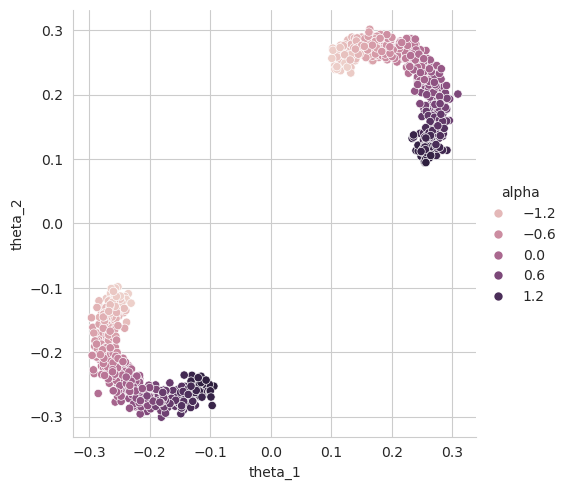

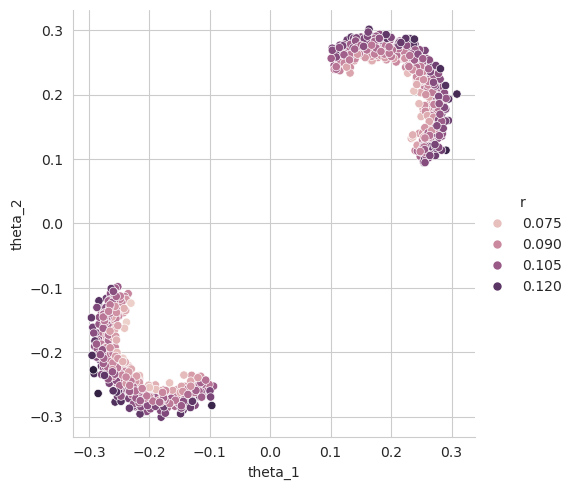

In [5]:
sns.relplot(data, x="theta_1", y="theta_2", hue="alpha")
plt.show()
sns.relplot(data, x="theta_1", y="theta_2", hue="r")
plt.show()

### Train a neural network to approximate the posterior

We start by defining some hyperparameters.

In [6]:
epochs = 10
num_batches = 1000
batch_size = 2048
memory_budget = "2 GB"

Define the approximator. We use Flow Matching as the inference network. This network should learn to infer $\theta$ from $x$, which we specify in the data adapter.

In [7]:
inference_network = bf.networks.CouplingFlow(subnet="mlp", subnet_kwargs=dict(depth=4, width=512))
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta", "r", "alpha"],
    inference_conditions=["x"],
)

approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

Define some necessary training parameters. We use a cosine learning rate schedule.

In [8]:
learning_rate = keras.optimizers.schedules.CosineDecay(
    1e-3, epochs * num_batches, 1e-6
)
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
    global_clipnorm=1.0,
)

In [9]:
approximator.compile(optimizer=optimizer)

Finally, fit the network to the data.

In [10]:
approximator.fit(
    simulator=simulator,
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    memory_budget=memory_budget,
    # we don't need workers or multiprocessing
    # because our dataset is small and we train on the cpu
    workers=1,
    use_multiprocessing=False,
)

INFO:bayesflow:Building dataset from simulator instance of TwoMoonsSimulator.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - inference/loss: -6.2843 - loss: -6.2843
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - inference/loss: -7.9407 - loss: -7.9407
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -8.8750 - loss: -8.8750
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -9.5735 - loss: -9.5735
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -10.2939 - loss: -10.2939
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -11.0366 - loss: -11.0366
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -12.0219 - loss: -12.0219
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -13.2367 - loss: -13.2367
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -14.7136 - loss: -14.7136
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - inference/loss: -15.8375 - loss: -15.8375


### Sample from the posterior

If the network is trained well, the distribution should look like the target distribution we visualized earlier.

Instead of rejection sampling, we can now explicitly pass $x = 0$ to the approximator and sample from the posterior, which is much faster.

In [11]:
data = approximator.sample(
    batch_shape=(1024,),
    data={"x": np.zeros((1024, 2))},
)
data = bf.utils.split_tensors(data)
data = keras.tree.map_structure(keras.ops.convert_to_numpy, data)

data.keys()

dict_keys(['theta_1', 'theta_2', 'r', 'alpha'])

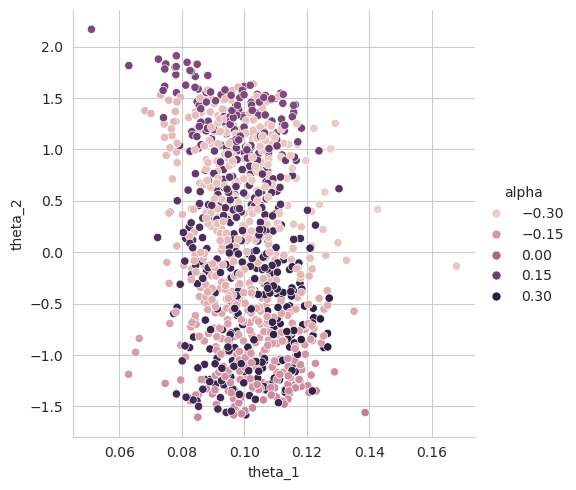

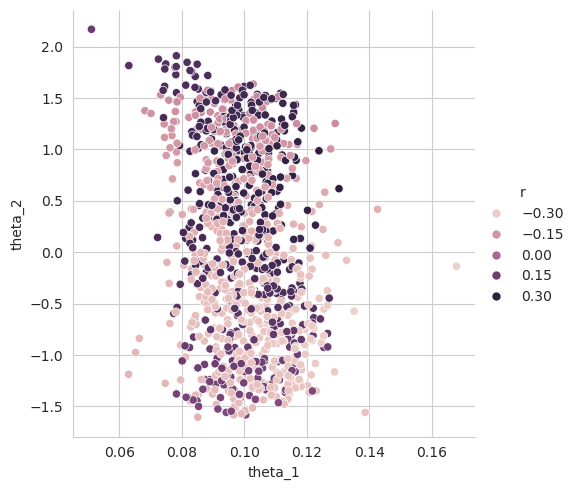

In [12]:
sns.relplot(data, x="theta_1", y="theta_2", hue="alpha")
plt.show()
sns.relplot(data, x="theta_1", y="theta_2", hue="r")
plt.show()